# Pycox: DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example


In [1]:
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ! pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

# from pycox.models import CoxPH
# from pycox.evaluation import EvalSurv

os.chdir("../")
from pycox.models.cox import CoxPH, CoxPHStratified
from pycox.evaluation.eval_surv import EvalSurv, EvalSurvStratified
from scr.utils import *
from scr.runDeepSurvModels import *

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Network Setup

In [10]:
subset = [50, 500, 1000, 2000, 5000]
batch_sizes = [8, 16, 16, 32, 64] #[8, 16, 16, 32, 32, 64]
runs = [5,5,5,5,5]
survival_cols = ['time', 'status']

learning_rate = 1e-4
parameters = {
    'num_nodes': [32, 32],
    'out_features': 1,
    'batch_norm' :True,
    'dropout' : 0.2,
    'output_bias' : True
}

In [11]:
from abc import ABC, abstractmethod

class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, dataName=None, hyperparameters=None):
        self.train_df=train_df
        self.test_df=test_df
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.model = None
        self.modelString = 'deepsurv-torch'
        
    def run_deepsurv(self, subset, batch_sizes, runs,
                    kwargs, time_col='time',status_col='status',
                    val_size=0.2, epochs = 500,
                    learning_rate = 1e-3, verbose = True,
                    patience = 20, min_delta=5e-2, print_scores=False):
        
        n_train, model_time, train_scores, test_scores = [],[],[],[]
        
        for (n, batch_size, n_run) in zip(subset, batch_sizes, runs): 
            
            run_train_scores, run_test_scores, run_time = [],[],[]
            for run in range(n_run):
                if n < self.train_df.shape[0]:
                    train_sub,_ = train_test_split(self.train_df,
                                                train_size=n/self.train_df.shape[0], 
                                                shuffle=True, random_state=run,
                                                stratify=self.train_df[status_col])
                else:
                    train_sub = self.train_df
                    
                tr_df, val_df = train_test_split(train_sub, 
                                                test_size=val_size,
                                                shuffle=True, random_state=run,
                                                stratify=train_sub[status_col])
                
                # Transform data
                covariate_cols = [col for col in self.train_df.columns if col not in survival_cols]
                standardize = [([col], StandardScaler()) for col in covariate_cols]
                # leave = [(col, None) for col in survival_cols]
                x_mapper = DataFrameMapper(standardize)

                # gene expression data
                x_train = x_mapper.fit_transform(tr_df[covariate_cols]).astype('float32')
                x_val = x_mapper.fit_transform(val_df[covariate_cols]).astype('float32')
                x_test = x_mapper.transform(self.test_df[covariate_cols]).astype('float32')
                # prepare labels
                get_target = lambda df: (df[time_col].values, df[status_col].values)
                y_train = get_target(tr_df)
                y_val = get_target(val_df)
                t_test, e_test = get_target(self.test_df)
                val = x_val, y_val
            
                # ================== Build Neural Net ==================
                ## define parameters (hyperparam tuning)
                kwargs['in_features'] = x_train.shape[1]
                net = tt.practical.MLPVanilla(**kwargs)
                # define optimizer 
                optimizer = tt.optim.Adam(weight_decay=0.01)
                model = CoxPH(net, optimizer)
                model.optimizer.set_lr(learning_rate)

                # ==================Train Model ==================   
                callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
                
                start = time.time() # Record iteration start time
                log = model.fit(x_train, y_train,
                                batch_size,
                                epochs,
                                callbacks, 
                                verbose=verbose,
                                val_data=val, val_batch_size=batch_size
                                )
                stop = time.time() # Record time when training finished
                duration = round(stop - start, 2)

                # ================= Evaluation ===================
                _ = model.compute_baseline_hazards()
                te_surv = model.predict_surv_df(x_test)
                tr_surv = model.predict_surv_df(x_train)

                train_ev = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km')
                train_c  = train_ev.concordance_td()
                test_ev  = EvalSurv(te_surv, t_test, e_test, censor_surv='km')
                test_c   = test_ev.concordance_td()
                
                n_train.append(n)
                model_time.append(duration)
                train_scores.append(train_c)
                test_scores.append(test_c)
                    
                run_train_scores.append(train_c)
                run_test_scores.append(test_c)
                run_time.append(duration)
            
            if print_scores:
                print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                
                
        # ============== Save results ===============
        model_results = pd.DataFrame({
            'n train': n_train, 
            'train time':model_time,
            'train score':train_scores, 
            'test score':test_scores}
        )
        return model_results
    
    def write(self, model_results, out_dir=None, fileName='model.results.txt'):
        
        out_dir=os.path.join('models', self.dataName, self.modelString) if out_dir is None else out_dir
        os.makedirs(out_dir, exist_ok=True)
        
        # save results as txt or csv file
        if 'txt' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
        elif 'csv' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), index=False)
        else:
            print('Please specify a file name with either a txt or csv extension.')  


In [5]:
## Function to plot simulated data -- later add to utils!!
def plot_simulation_data(train_df, test_df):
    # observe data
    print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
    print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
    print('Survival time distribution:')
    _, ax = plt.subplots(figsize=(3,3))
    ax.hist(train_df['time'], label='train')
    # ax.hist(val_df['time'],   label='val', alpha=.8)
    ax.hist(test_df['time'], label='test', alpha=0.6)
    ax.legend(fontsize=12)
    plt.show()

## TCGA real world data

In [6]:
brca_clin  = pd.read_csv(os.path.join("data", "batch", "TCGA_miRNA_clinical.csv"))
brca_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-BRCA-3.csv"), index_col=0)

brca_clin = brca_clin.rename(columns={'bcr_patient_barcode':'Sample'})

brca = pd.merge(brca_mirna, brca_clin, on='Sample', how = 'left')
brca_df = brca.loc[:, ['days_to_death', 
                       'days_to_last_followup'] +
                    [col for col in brca.columns if 'hsa' in col]]

Number of events: 102
Number of censored cases: 912


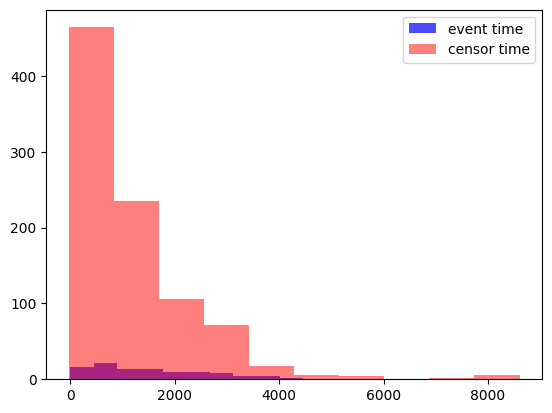

In [7]:
deathtt = brca_df['days_to_death'][~np.isnan(brca_df['days_to_death'])]
censortt = brca_df['days_to_last_followup'][~np.isnan(brca_df['days_to_last_followup'])]
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [8]:
# get censoring status and survival time
brca_df['status'] = [int(i) for i in ~np.isnan(brca_df['days_to_death'])]

brca_df['time'] = brca_df['days_to_death']
brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]

/tmp/ipykernel_15766/794049930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]


In [9]:
brca_df = brca_df.drop(columns=['days_to_death',"days_to_last_followup"])
brca_df = brca_df.dropna().reset_index(drop=True)

brca_df = brca_df[brca_df['time']>0] 

In [11]:
print("Event rate in the TCGA BRCA data: %f" % (sum(brca_df['status']) / brca_df.shape[0]))

Event rate in the TCGA BRCA data: 0.100498


In [20]:
train_df, test_df = train_test_split(brca_df, test_size=0.2, random_state=42, stratify=brca_df['status'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="tcga-brca")
ds_results = ds.run_deepsurv(subset,epochs=100,
                            batch_sizes=[64],
                            patience=30, min_delta=1e-2,
                            kwargs=parameters, verbose=True, print_scores=False)
ds_results

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
10:	[0s / 0s],	
11:	[0s / 0s],	
12:	[0s / 0s],	
13:	[0s / 0s],	
14:	[0s / 0s],	
15:	[0s / 0s],	
16:	[0s / 0s],	
17:	[0s / 0s],	
18:	[0s / 0s],	
19:	[0s / 0s],	
20:	[0s / 0s],	
21:	[0s / 0s],	
22:	[0s / 0s],	
23:	[0s / 0s],	
24:	[0s / 0s],	
25:	[0s / 0s],	
26:	[0s / 0s],	
27:	[0s / 0s],	
28:	[0s / 0s],	
29:	[0s / 0s],	


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

,n train,train time,train score,test score
0,804,0.88,0.55795,0.452331


## Simulated Data with Batch effect

In [25]:
# load simulated data
df_train_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_train_noBatch.csv")).iloc[:, 1:]
df_train_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_train_withBatch.csv")).iloc[:, 1:]
df_test_noBatch    = pd.read_csv(os.path.join("data","batch", "demo_sim_test_noBatch.csv")).iloc[:, 1:]

print("Event rate in the train data: %f" % (sum(df_train_noBatch['delta']) / df_train_noBatch.shape[0]))
print("Event rate in the test data: %f" % (sum(df_test_noBatch['delta']) / df_test_noBatch.shape[0])) 

Event rate in the train data: 0.760417
Event rate in the test data: 0.760417


In [ ]:
learning_rate = 1e-3
parameters = {
    'num_nodes': [32, 32],
    'out_features': 1,
    'batch_norm' :True,
    'dropout' : 0.2,
    'output_bias' : True
}

In [ ]:
subset = [24, 48, 96] #[train_df.shape[0]]
batch_sizes = [8,8,8]
ds = DeepSurvPipeline(train_df=df_train_withBatch.drop(columns='batch_id'), test_df=df_test_noBatch, dataName="vh-with-batch")
ds_results = ds.run_deepsurv(subset=subset, time_col='t', status_col='delta',
                            batch_sizes=batch_sizes,
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=False, print_scores=True)
ds.write(ds_results)
ds_results

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=24 Training time (0.48s): Train C-Index: 0.939 | Test C-index: 0.702


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=48 Training time (0.81s): Train C-Index: 0.895 | Test C-index: 0.765
N=96 Training time (1.79s): Train C-Index: 0.848 | Test C-index: 0.846


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

,n train,train time,train score,test score
0,24,0.48,0.938776,0.702295
1,48,0.81,0.894654,0.764855
2,96,1.79,0.847985,0.845652


In [36]:
ds = DeepSurvPipeline(train_df=df_train_noBatch, test_df=df_test_noBatch, dataName="vh-no-batch")
ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
                            batch_sizes=batch_sizes,
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=False, print_scores=True)

ds.write(ds_results)

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=24 Training time (0.19s): Train C-Index: 0.605 | Test C-index: 0.657


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=48 Training time (1.51s): Train C-Index: 0.97 | Test C-index: 0.813
N=96 Training time (2.15s): Train C-Index: 0.955 | Test C-index: 0.897


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

## Load Data

### Linear: Moderate

In [6]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest", '20000']
DATANAME = 'linear-moderate'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

In [13]:
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName=DATANAME)
ds_results = ds.run_deepsurv(subset, 
                            batch_sizes=[8, 16, 16, 32, 64],
                            runs=runs,
                            patience=25, min_delta=1e-2, learning_rate=learning_rate,
                            kwargs=parameters, verbose=False, print_scores=True)

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=50 Training time (0.472s): Train C-Index: 0.805 | Test C-index: 0.622 (Mean)


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=500 Training time (2.1079999999999997s): Train C-Index: 0.9 | Test C-index: 0.769 (Mean)


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=1000 Training time (4.08s): Train C-Index: 0.88 | Test C-index: 0.788 (Mean)


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=2000 Training time (3.9560000000000004s): Train C-Index: 0.867 | Test C-index: 0.797 (Mean)


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=5000 Training time (4.79s): Train C-Index: 0.844 | Test C-index: 0.812 (Mean)


In [14]:
ds.write(model_results=ds_results, fileName="model.results.multiple.txt")

### Linear: Weak

Event rate in train set: 0.750333
Event rate in test set: 0.750500
Survival time distribution:


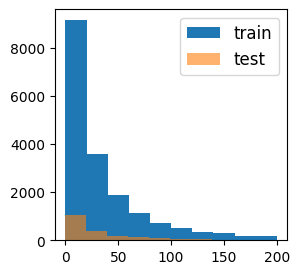

In [16]:
# prepare data
folder = 'linear'
keywords = ['weak', "latest", '20000']
DATANAME = 'linear-weak'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

# observe data
print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [25]:
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName=DATANAME)
ds_results = ds.run_deepsurv(subset, 
                            batch_sizes=[8, 16, 16, 32, 64], runs=runs,
                            patience=25, min_delta=1e-2, learning_rate=1e-3,
                            kwargs=parameters, verbose=False, print_scores=True)

/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_

N=50 Training time (0.304s): Train C-Index: 0.748 | Test C-index: 0.522 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=500 Training time (1.6939999999999997s): Train C-Index: 0.809 | Test C-index: 0.636 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=1000 Training time (2.942s): Train C-Index: 0.759 | Test C-index: 0.652 (Mean)
N=2000 Training time (3.118s): Train C-Index: 0.766 | Test C-index: 0.679 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=5000 Training time (4.586s): Train C-Index: 0.759 | Test C-index: 0.695 (Mean)


In [26]:
ds.write(model_results=ds_results, fileName="model.results.multiple.txt")
# out_dir = os.path.join('models', DATANAME, 'deepsurv-torch')
# os.makedirs(out_dir, exist_ok=True)
# ds_results.to_csv(
#     os.path.join(out_dir,"model.results.txt"), sep='\t'
# )

In [27]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Nonliear: Quadratic terms

Event rate in train set: 0.746222
Event rate in test set: 0.746000
Survival time distribution:


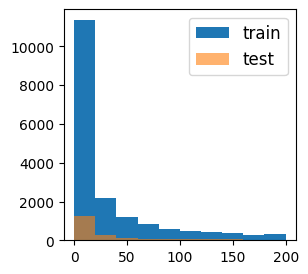

In [28]:
# prepare data
folder = 'nonlinear'
keywords = ['quadratic', "latest", '20000']
DATANAME = 'nl-quadratic'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [30]:
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName=DATANAME)
ds_results = ds.run_deepsurv(subset, 
                            batch_sizes=[8, 16, 16, 32, 64], runs=runs,
                            patience=25, min_delta=1e-2, learning_rate=1e-3,
                            kwargs=parameters, verbose=False, print_scores=True)

/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=50 Training time (0.5199999999999999s): Train C-Index: 0.857 | Test C-index: 0.533 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=500 Training time (1.8799999999999997s): Train C-Index: 0.861 | Test C-index: 0.667 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=1000 Training time (3.6759999999999997s): Train C-Index: 0.852 | Test C-index: 0.708 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=2000 Training time (5.8020000000000005s): Train C-Index: 0.896 | Test C-index: 0.768 (Mean)
N=5000 Training time (7.475999999999999s): Train C-Index: 0.876 | Test C-index: 0.817 (Mean)


In [31]:
ds.write(ds_results, fileName="model.results.multiple.txt")

### Nonliear: Quadratic Interaction

Event rate in train set: 0.750000
Event rate in test set: 0.750000
Survival time distribution:


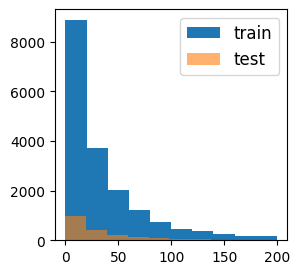

In [32]:
# prepare data
folder = 'nonlinear'
keywords = ['interaction', "latest", '20000']
DATANAME = 'nl-interaction'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [33]:
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName=DATANAME)
ds_results = ds.run_deepsurv(subset, 
                            batch_sizes=[8, 16, 16, 32, 64], runs=runs,
                            patience=25, min_delta=1e-2, learning_rate=1e-3,
                            kwargs=parameters, verbose=False, print_scores=True)
ds.write(ds_results, fileName="model.results.multiple.txt")

/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=50 Training time (0.568s): Train C-Index: 0.867 | Test C-index: 0.542 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=500 Training time (1.506s): Train C-Index: 0.775 | Test C-index: 0.601 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=1000 Training time (2.998s): Train C-Index: 0.752 | Test C-index: 0.617 (Mean)
N=2000 Training time (3.04s): Train C-Index: 0.714 | Test C-index: 0.625 (Mean)
N=5000 Training time (4.409999999999999s): Train C-Index: 0.714 | Test C-index: 0.654 (Mean)


### Nonlinear: Sine

Event rate in train set: 0.748333
Event rate in test set: 0.748500
Survival time distribution:


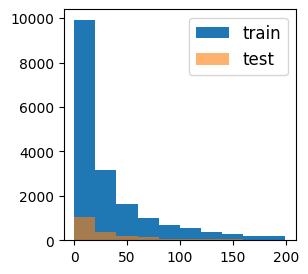

In [34]:
# prepare data
folder = 'nonlinear'
keywords = ['sine', "latest", '20000']
DATANAME = 'nl-sine'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
plot_simulation_data(train_df, test_df)

In [35]:
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName=DATANAME)
ds_results = ds.run_deepsurv(subset, 
                            batch_sizes=[8, 16, 16, 32, 64], runs=runs,
                            patience=25, min_delta=1e-2, learning_rate=1e-3,
                            kwargs=parameters, verbose=False, print_scores=True)
ds.write(ds_results, fileName="model.results.multiple.txt")


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=50 Training time (0.40800000000000003s): Train C-Index: 0.861 | Test C-index: 0.533 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=500 Training time (1.3739999999999999s): Train C-Index: 0.736 | Test C-index: 0.594 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=1000 Training time (2.8280000000000003s): Train C-Index: 0.74 | Test C-index: 0.633 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=2000 Training time (2.928s): Train C-Index: 0.724 | Test C-index: 0.645 (Mean)


/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/home/nfs/dengy/dl-survival-miRNA/pycox/models/cox.py:259: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


N=5000 Training time (4.226s): Train C-Index: 0.726 | Test C-index: 0.674 (Mean)


In [36]:
ds_results

,n train,train time,train score,test score
0,50,0.46,0.922840,0.530844
1,50,0.53,0.943343,0.525017
2,50,0.46,0.937778,0.555349
3,50,0.32,0.827534,0.510815
4,50,0.27,0.674312,0.544101
5,500,1.60,0.826672,0.619015
6,500,1.32,0.719066,0.596790
7,500,1.22,0.639395,0.558494
8,500,1.46,0.780420,0.606633
9,500,1.27,0.716527,0.590008


# Full process

In [4]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
DATANAME = 'linear-moderate'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

## Feature transforms
We will standardize the numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [5]:
survival_cols = ['time', 'status']

In [6]:
tr_df, val_df = train_test_split(train_df, 
                                test_size=0.2,
                                shuffle=True, random_state=42,
                                stratify=train_df['status'])

# Transform data
covariate_cols = [col for col in train_df.columns if col not in survival_cols]
standardize = [([col], StandardScaler()) for col in covariate_cols]
leave = [(col, None) for col in survival_cols]
x_mapper = DataFrameMapper(standardize)

# gene expression data
x_train = x_mapper.fit_transform(tr_df[covariate_cols]).astype('float32')
x_val = x_mapper.fit_transform(val_df[covariate_cols]).astype('float32')
x_test = x_mapper.transform(test_df[covariate_cols]).astype('float32')

# prepare labels
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(tr_df)
y_val = get_target(val_df)
t_test, e_test = get_target(test_df)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [7]:
in_features = x_train.shape[1]
num_nodes = [32, 16]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [8]:
# optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, 
#                             cycle_eta_multiplier=0.8,
#                             cycle_multiplier=2)

optimizer = tt.optim.Adam(weight_decay=0.01)
# model = CoxPH(net, optimizer)

be_model = CoxPHStratified(net, optimizer)

# batch_size = 32
# lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
# _ = lrfinder.plot()
# best_lr = lrfinder.get_best_lr()
# best_lr

# Often, this learning rate is a little high, so we instead set it manually to 0.001
be_model.optimizer.set_lr(1e-3)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [9]:
%%time
batch_size = 64
epochs = 500
callbacks = [tt.callbacks.EarlyStopping(patience=20, min_delta=5e-2)]
verbose = True

log = be_model.fit(x_train, y_train,
                np.ones(len(y_train[1])),
                batch_size,
                epochs,
                callbacks, 
                verbose=True,
                val_data=val, val_batch_size=batch_size
                )

TypeError: forward() missing 1 required positional argument: 'batch_indices'

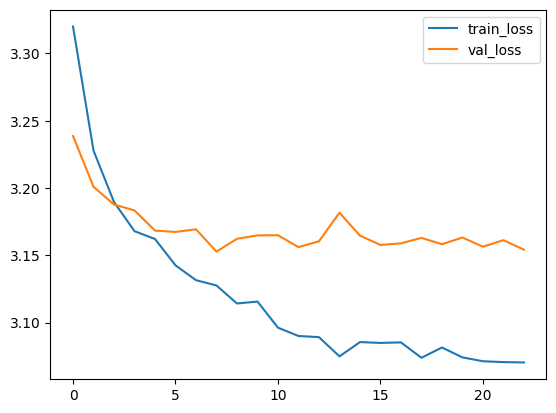

In [71]:
_ = log.plot()

We can get the partial log-likelihood

In [72]:
model.partial_log_likelihood(x_train, y_train).mean()

-7.709625

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

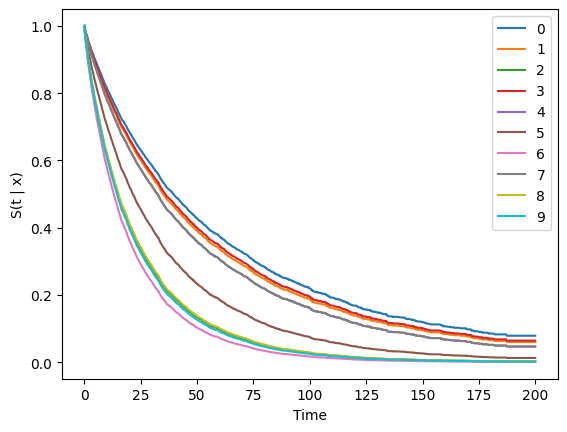

In [73]:
_ = model.compute_baseline_hazards()
te_surv = model.predict_surv_df(x_test)
tr_surv = model.predict_surv_df(x_train)
# plot predicted KM for first 5 observations
te_surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [74]:
test_df.reset_index(drop=True).iloc[:10, -2:]

,time,status
0,28.675455,1
1,21.362043,1
2,4.319190,1
3,83.340747,0
4,1.982618,1
5,13.456412,0
6,1.730307,1
7,4.521371,1
8,17.994631,1
9,41.959424,1


## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [75]:
train_ev = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km')
train_c  = train_ev.concordance_td()
test_ev  = EvalSurv(te_surv, t_test, e_test, censor_surv='km')
test_c   = test_ev.concordance_td()

print(f"Train C-Index: {round(train_c, 3)} | Test C-index: {round(test_c,3)}")

Train C-Index: 0.715 | Test C-index: 0.689


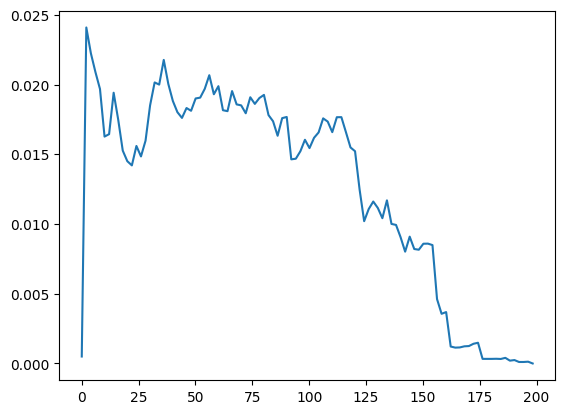

In [25]:
time_grid = np.linspace(t_test.min(), t_test.max(), 100)
_ = test_ev.brier_score(time_grid).plot()

In [27]:
print(test_ev.integrated_brier_score(time_grid))

0.012779221006460794
